In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from shogun import *
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from scripts import utils
from datetime import datetime, timedelta

import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [15]:
%%time

query_output = utils.get_query_from_file('sql/vitals-timeseries-24hrs.sql', con)
query_output.to_csv('./timeseries-heartrate.csv', index=False)
query_output.head()

CPU times: user 17.8 s, sys: 2.19 s, total: 20 s
Wall time: 1min 3s


In [3]:
query_output = pd.read_csv('./timeseries-heartrate.csv') #, index_col='timestamp') #.dropna().reset_index(drop=True)

query_output = query_output.dropna(subset=['timestamp'], how='any')
query_output= query_output.set_index('timestamp')

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1week_expire_flag', 'hospital1day_expire_flag',
                   'dod_hosp']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type']

feature_names = [
            # Vital signs
            'heartrate'
                 
            ]

query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean())
query_output.index = pd.to_datetime(query_output.index)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names)]
outcomes['subject_id'] = features.subject_id

features.head()

,admission_type,age_icu_in,first_careunit,gender,heartrate,subject_id
timestamp,,,,,,
2111-11-07 02:45:00,1,37.446714,2,0,101.0,891
2111-11-07 10:00:00,1,37.446714,2,0,100.0,891
2111-11-07 21:00:00,1,37.446714,2,0,95.0,891
2111-11-07 16:30:00,1,37.446714,2,0,86.0,891
2111-11-07 03:00:00,1,37.446714,2,0,86.0,891


In [24]:
%%time

df_features = pd.DataFrame()
df_labels = pd.DataFrame()

for subject_id, group in features.groupby('subject_id'):
    df_resampled = group.resample('1H').mean().ffill()
    death_time = outcomes.loc[outcomes.subject_id == subject_id].dod_hosp[0]
    if not pd.isnull(death_time):
        df_resampled.loc[df_resampled.index >= death_time, feature_names] = 0    
    df_patient_features = pd.DataFrame(index=df_resampled.index)

    # could have more than heart rate in the df for the patient
    for var in feature_names:
        df_patient_features["%s-raw"%var]=df_resampled[var]

        # lagged features
        df_patient_features["%s-lagged_1d"%var] = df_resampled[var].shift(1)
        df_patient_features["%s-lagged_5d"%var] = df_resampled[var].shift(5)

        # filters
        window_days=6
        df_patient_features["%s-filter_mean_%dd" % (var,window_days)] = df_resampled[var].rolling(window_days).mean()
        df_patient_features["%s-filter_median_%dd" % (var,window_days)] = df_resampled[var].rolling(window_days).median()
        df_patient_features["%s-filter_min_%dd" % (var,window_days)] = df_resampled[var].rolling(window_days).min()
        df_patient_features["%s-filter_max_%dd" % (var, window_days)] = df_resampled[var].rolling(window_days).max()

    #forward fill missing values (since some might be NaN)
    df_patient_features.ffill(inplace=True)

    # drop rows with NaNs
    df_patient_features.dropna(axis=0, inplace=True)
    
    # add demographic information
    df_patient_features = pd.merge(df_patient_features, df_resampled, left_index=True, right_index=True) \
    .drop(['heartrate'], axis=1)
    
    # add labels
    df_patient_labels = pd.DataFrame(data=None, index=df_patient_features.index)

    df_patient_labels['dead'] = df_patient_labels.index >= death_time if not pd.isnull(death_time) else 0
    dies_in_days=1

    df_patient_labels["dead_in_%dd" % dies_in_days]= (df_patient_labels.index + timedelta(days=dies_in_days)) >= death_time \
                                            if not pd.isnull(death_time) else 0
    dies_in_days=7
    df_patient_labels["dead_in_%dd" % dies_in_days]= (df_patient_labels.index + timedelta(days=dies_in_days)) >= death_time \
                                            if not pd.isnull(death_time) else 0
    
    df_features = df_features.append(df_patient_features)
    df_labels = df_labels.append(df_patient_labels)
    
df_features.head()

CPU times: user 11min 2s, sys: 1min 2s, total: 12min 4s
Wall time: 12min 4s


In [25]:
df_features.head()

,heartrate-raw,heartrate-lagged_1d,heartrate-lagged_5d,heartrate-filter_mean_6d,heartrate-filter_median_6d,heartrate-filter_min_6d,heartrate-filter_max_6d,admission_type,age_icu_in,first_careunit,gender,subject_id
timestamp,,,,,,,,,,,,
2101-10-21 00:00:00,146.0,143.0,143.00,142.125000,143.00,125.5,155.75,1.0,76.526792,2.0,1.0,3.0
2101-10-21 01:00:00,141.0,146.0,155.75,141.791667,142.00,125.5,155.75,1.0,76.526792,2.0,1.0,3.0
2101-10-21 02:00:00,117.0,141.0,139.50,135.333333,140.25,117.0,146.00,1.0,76.526792,2.0,1.0,3.0
2101-10-21 03:00:00,114.0,117.0,125.50,131.083333,133.25,114.0,146.00,1.0,76.526792,2.0,1.0,3.0
2101-10-21 04:00:00,116.0,114.0,143.00,129.500000,129.00,114.0,146.00,1.0,76.526792,2.0,1.0,3.0


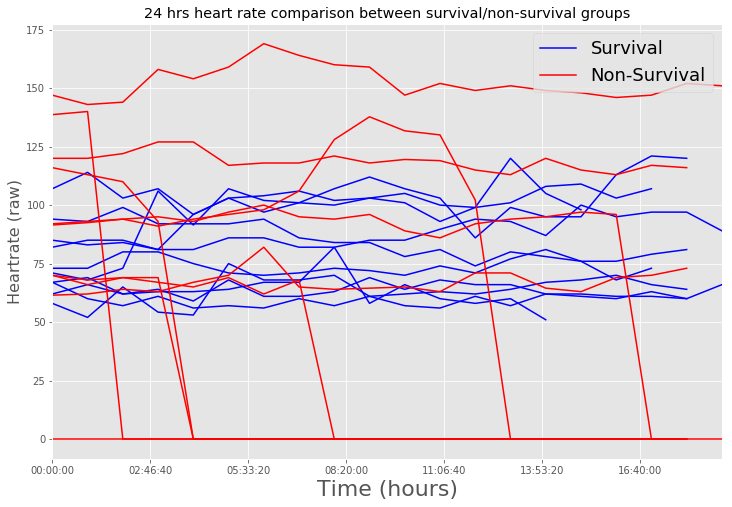

In [34]:
survival = df_features.loc[df_labels.dead_in_1d == 0]
non_survival = df_features.loc[df_labels.dead_in_1d != 0]

surv_rows = np.random.choice(survival.subject_id.values, 10)
non_surv_rows = np.random.choice(non_survival.subject_id.values, 10)

survival = survival.loc[survival.subject_id.isin(surv_rows)]
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

fig, ax = plt.subplots(figsize=(12, 8))

for title, group in survival.groupby('subject_id'):
    group.plot(y='heartrate-raw', x=group.index - group.index[0], label='survival', ax=ax, color='blue')

for title, group in non_survival.groupby('subject_id'):
    group.plot(y='heartrate-raw', x=group.index - group.index[0], label='non-survival', ax=ax, color='red')    

legend = plt.legend(['Survival', 'Non-Survival'], fontsize=18)
legend.get_lines()[1].set_color('red')
plt.xlabel('Time (hours)', fontsize=22)
plt.ylabel('Heartrate (raw)', fontsize=16)
plt.title('24 hrs heart rate comparison between survival/non-survival groups')
plt.show()

In [106]:
n_trees = 100

X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
y = df_labels['dead_in_1d'].reset_index(drop=True)

split = int(len(X) * 0.5)

idx = np.random.permutation(np.arange(len(y)))
train_idx = idx[:split]
test_idx = idx[split:]

X_train = RealFeatures(np.array(X.loc[train_idx].T))
X_test = RealFeatures(np.array(X.loc[test_idx].T))

y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

('Number of training samples:', 295094)
('Number of testing samples:', 295094)


True

## SVM

In [110]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test.get_binary_for_class(1))

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 97.87457555897443)
('Area under ROC(%):', 0.6281762915480587)
CPU times: user 4.28 s, sys: 12 ms, total: 4.3 s
Wall time: 1.18 s


## Random Forest

In [ ]:
%%time

feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

m_vote = MajorityVote()

rand_forest = RandomForest(X_train, y_train, n_trees)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)

rand_forest.train()

y_pred = rand_forest.apply_binary(X_test)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()